In [1]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd

import sklearn
import scipy

import sys
import os
import pathlib
import itertools
import glob
import re

package_path = os.path.join(pathlib.Path.home(), "mkvchain")
sys.path.append(package_path)
from model import FeatureDependentMarkovChain

In [2]:
root = pathlib.Path.home()
pt1 = os.path.join(root, 'research', 'GADS_Processed', "trajectories_with_features")

def glob_re(pattern, strings):
    return list(filter(re.compile(pattern).match, strings))

filenames = glob_re(r"gen_\d+_type_200_dtgrp_\d+_rating_\d+_state_Texas_raw.csv", os.listdir(pt1))

In [3]:
weather_pt = os.path.join(root, 'research', 'NOAA_WEATHER_DATA', "processed")
weather_files = glob.glob(weather_pt + "/*.csv")

my_w_list = []

for w in weather_files:
    weather = pd.read_csv(os.path.join(weather_pt, w))
    weather.set_index(pd.DatetimeIndex(weather["Unnamed: 0"]), inplace=True)
    weather.drop(columns="Unnamed: 0", inplace=True)
    my_w_list.append(weather)

In [18]:

mylist = []

for f in filenames:
    gen_id = int(re.findall(r"gen_(\d+)_.+", f)[0])

    data = pd.read_csv(os.path.join(pt1,f))
    data.set_index(pd.DatetimeIndex(data["x"]), inplace=True)
    data = data[~data.index.duplicated()]
    data.rename(columns={"COAST": "y5", "NORTH_C" : "y5"}, inplace=True)

    for w in my_w_list:
        data = data.join(w)


    po_idx = np.where(data["y2"].values == 3)[0]
    end_of_event = np.concat([[False], np.diff(po_idx) != 1])
    end_of_event_idx = po_idx[end_of_event]

    idx = range(len(data))
    my_data = np.zeros(len(data))

    for i in idx:
        events_before_i = np.array([j for j in end_of_event_idx if j < i])
        if len(events_before_i) > 1:
            closest_idx = np.argmin(i - events_before_i)
            my_event_idx = events_before_i[closest_idx]
            hours_since_event = (i - my_event_idx)
        else:
            hours_since_event = None
        my_data[i] = hours_since_event
    
    data["y6"] = my_data

    # mo_idx = np.where(d["y2"].values == 4)[0]
    # if len(mo_idx) < 1:
    #     my_data = None
    # else:
    #     end_of_event = np.concat([[False], np.diff(mo_idx) != 1])
    #     end_of_event_idx = mo_idx[end_of_event]

    #     idx = range(len(d))
    #     my_data = np.zeros(len(d))

    #     for i in idx:
    #         events_before_i = np.array([j for j in end_of_event_idx if j < i])
    #         if len(events_before_i) > 1:
    #             closest_idx = np.argmin(i - events_before_i)
    #             my_event_idx = events_before_i[closest_idx]
    #             hours_since_event = (i - my_event_idx)
    #         else:
    #             hours_since_event = None
    #         my_data[i] = hours_since_event
    
    # d["y7"] = my_data

    data["y8"] = data.index.month

    idx = data.index[np.where(data["Tmax"] == 0)[0]]
    data.loc[idx, "Tmax"] = np.nan

    mylist.append(data)


In [19]:
data.index[np.where(data["Tmax"] == 0)[0]]

DatetimeIndex([], dtype='datetime64[ns]', name='x', freq=None)

In [21]:
d = mylist[0]
for c in ['y3', 'y5', 'y4', 'Pcp', "Tmin", "Tmax", 'y6', 'y8']:
    contingency_table = pd.crosstab(d["y2"], d[c])
    try:
        res = scipy.stats.chi2_contingency(contingency_table)
    except:
        continue
    print(c, res.pvalue)

y3 0.0
y5 0.00015329933491778217
y4 0.0
Pcp 0.0
Tmin 0.0
Tmax 0.0
y6 0.03197595686923424
y8 0.0


In [22]:
states_new = []
features_new = []
lengths_new = []

for d in mylist:
    states = d["y2"].values.tolist()
    features = d[['y3', 'y5', 'y4', 'Pcp', "Tmin", "Tmax", 'y6', 'y8']].values
    l = len(d)

    states_new += [states]
    features_new += [features]
    lengths_new += [l]

states = np.concatenate(states_new).astype(int)
states -= 1
features = np.vstack(features_new)
lengths = np.array(lengths_new)

In [23]:
train_idx = 2 # int(lengths.size * .8)
val_idx = 3 #int(lengths.size * .9)

lengths_train = lengths[:train_idx]
lengths_val = lengths[train_idx:val_idx]
lengths_test = lengths[val_idx:]

states_train = states[:lengths_train.sum()]
states_val = states[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
states_test = states[lengths_train.sum()+lengths_val.sum():]

features_train = features[:lengths_train.sum()]
features_val = features[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
features_test = features[lengths_train.sum()+lengths_val.sum():]

In [24]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
ss = StandardScaler()

features_train = ss.fit_transform(features_train)
features_val = ss.transform(features_val)
features_test = ss.transform(features_test)
n = 4

In [25]:
n = 4
model1 = FeatureDependentMarkovChain(n, lam_frob=0, n_iter=1)
model1.fit(states_train, features_train*0, lengths_train, verbose=False)
train1, val1, test1 = model1.score(states_train, features_train*0, lengths_train, average=False), \
    model1.score(states_val, features_val*0, lengths_val, average=False), \
    model1.score(states_test, features_test*0, lengths_test, average=False)
train1, val1, test1

(np.float64(-1364.0922350875608),
 np.float64(-2618.1144481957194),
 np.float64(-2128.9605492279884))

In [26]:
predictions = model1.predict(features_val)
for i, j in itertools.product(range(4), range(4)):
    y = predictions[:, i, j]
    val = len(np.unique(y.round(decimals=4)))
    print(f"{i} -> {j} : {val}")

0 -> 0 : 2
0 -> 1 : 2
0 -> 2 : 2
0 -> 3 : 2
1 -> 0 : 2
1 -> 1 : 2
1 -> 2 : 2
1 -> 3 : 2
2 -> 0 : 2
2 -> 1 : 2
2 -> 2 : 2
2 -> 3 : 2
3 -> 0 : 2
3 -> 1 : 2
3 -> 2 : 2
3 -> 3 : 2


In [27]:
from copy import deepcopy
train2, val2, test2 = -np.inf, -np.inf, -np.inf
best_lam = None
model2 = None
for lam in np.logspace(-3,-1,10):
    model = FeatureDependentMarkovChain(n, lam_frob=lam,  n_iter=1)
    model.As = deepcopy(model1.As)
    model.bs = deepcopy(model1.bs)
    model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)
    traini, vali, testi = model.score(states_train, features_train, lengths_train, average=False), \
          model.score(states_val, features_val, lengths_val, average=False), \
          model.score(states_test, features_test, lengths_test, average=False)
    if vali > val2:
        train2 = traini
        val2 = vali
        test2 = testi
        best_lam = lam
        model2 = model
train2, val2, test2

(np.float64(-1362.2452162257157),
 np.float64(-2617.3143233430096),
 np.float64(-2129.5038472020706))

In [28]:
model = FeatureDependentMarkovChain(n, lam_frob=best_lam, n_iter=1)
model.As = deepcopy(model1.As)
model.bs = deepcopy(model1.bs)
model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)

In [29]:
predictions2 = model.predict(features_test)
for i, j in itertools.product(range(4), range(4)):
    y = predictions2[:, i, j]
    val = len(np.unique(y.round(decimals=4)))
    print(f"{i} -> {j} : {val}")

0 -> 0 : 3
0 -> 1 : 2
0 -> 2 : 3
0 -> 3 : 2
1 -> 0 : 12
1 -> 1 : 13
1 -> 2 : 3
1 -> 3 : 2
2 -> 0 : 5
2 -> 1 : 2
2 -> 2 : 5
2 -> 3 : 2
3 -> 0 : 2
3 -> 1 : 2
3 -> 2 : 2
3 -> 3 : 2


In [34]:
feature_names = ['Age [Days]', 'Load [MW]', 'DOY', 'Pcp', "Tmin [F]", "Tmax [F]", 'Days since PO', 'Month']
features_test = features[lengths_train.sum()+lengths_val.sum():]

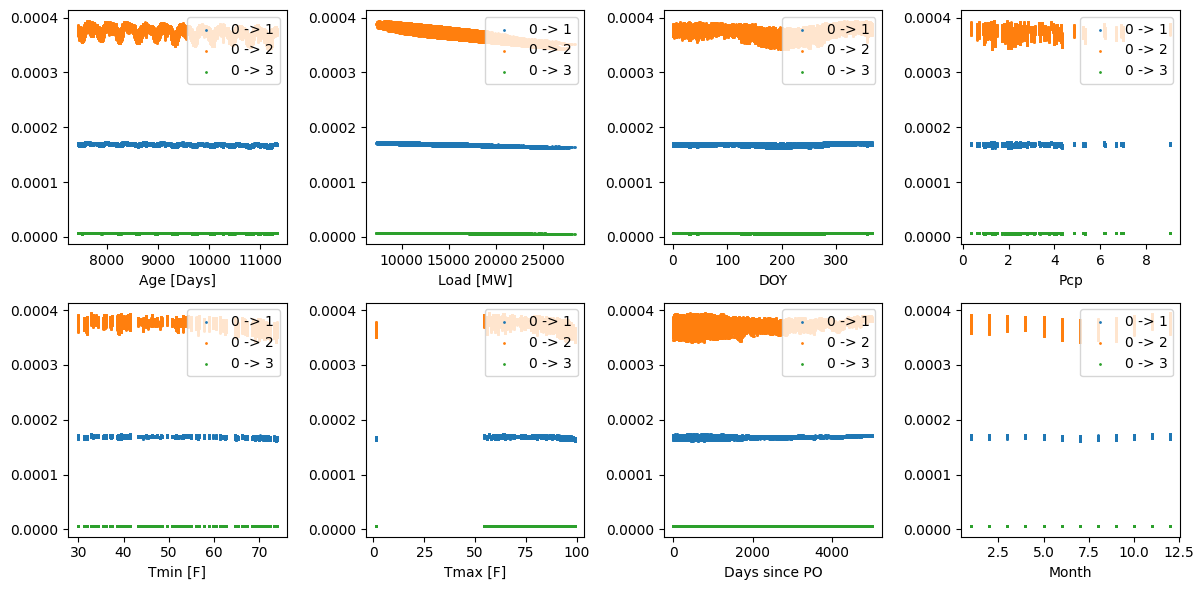

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6))

for i in range(8):

    if i//4 < 1:
        k = 0
        j = i
    else:
        k = 1
        j = np.mod(i, 4)
    f = features_test[:, i]

    for m, n in itertools.product([0], range(1,4)):
    
        ax[k, j].scatter(f, predictions2[:, m, n], s=1, label=f"{m} -> {n}")
    
    ax[k, j].set_xlabel(feature_names[i])
    ax[k, j].legend(loc='upper right')
    # ax[i, j].set_yscale('log')

fig.tight_layout()

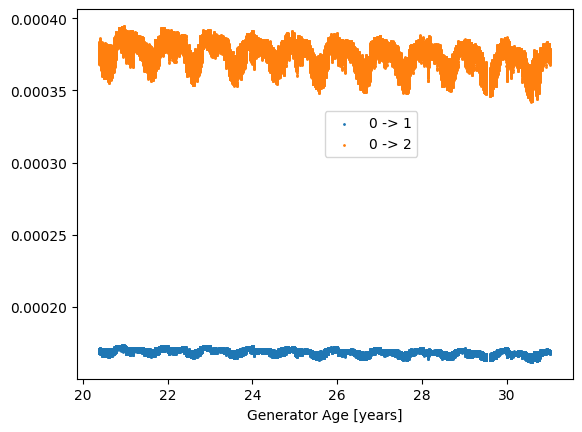

In [47]:
fig, ax = plt.subplots()

f = features_test[:, 0]

for m, n in itertools.product([0], range(1,3)):
    
    ax.scatter(f/365, predictions2[:, m, n], s=1, label=f"{m} -> {n}")

ax.set_xlabel("Generator Age [years]")
ax.legend(loc=(0.5, 0.6))

In [38]:
f/365

array([20.01369863, 20.01369863, 20.01369863, ..., 31.01917808,
       31.01917808, 31.01917808], shape=(96392,))

In [17]:
v = predictions2[:, 1, 0]
idx = ~np.isnan(v)
v = v[idx]
d = mylist[-1]

for c in ['y3', 'y5', 'y4', 'Pcp', "Tmin", "Tmax", 'y6', 'y8']:

    res = scipy.stats.pearsonr(d[c].values[idx], v)
    print(c, res.pvalue)

y3 0.0
y5 0.0
y4 0.0
Pcp 0.0
Tmin 0.0
Tmax 0.0
y6 0.0
y8 0.0


In [14]:
v = predictions2[:, 1, 0]
d = mylist[-1]

for c in ['y3', 'y5', 'y4', 'Pcp', "Tmin", "Tmax", 'y6', 'y8']:
    contingency_table = pd.crosstab(v, d[c])
    try:
        res = scipy.stats.chi2_contingency(contingency_table)
    except:
        continue
    print(c, res.pvalue)

: 

In [1]:
d[c]

NameError: name 'd' is not defined